In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [2]:
tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'arc',
 'bair_robot_pushing_small',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'cos_e',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'emnist',
 'eraser_multi_rc',
 'esnli',
 'eurosat',
 'fashion_mnist',
 'flic',
 'flores',
 'food101',
 'forest_fires',
 'gap',
 'ge

In [3]:
len(list(tfds.list_builders()))

173

In [4]:
valid_data = tfds.load('cifar10', split='train[:10%]')
train_data, info = tfds.load('cifar10', split='train[10%:100%]', with_info=True)


test_data = tfds.load('cifar10', split=tfds.Split.TEST)

In [5]:
print(info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



In [6]:
labels_dict = dict(enumerate(info.features['label'].names))
labels_dict

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [7]:
train_dict = {}

for data in train_data:
    label = data['label'].numpy()
    train_dict[label] = train_dict.setdefault(label, 0) + 1
print(train_dict)

{7: 4529, 9: 4472, 8: 4481, 3: 4503, 4: 4514, 5: 4482, 6: 4510, 2: 4500, 0: 4485, 1: 4524}


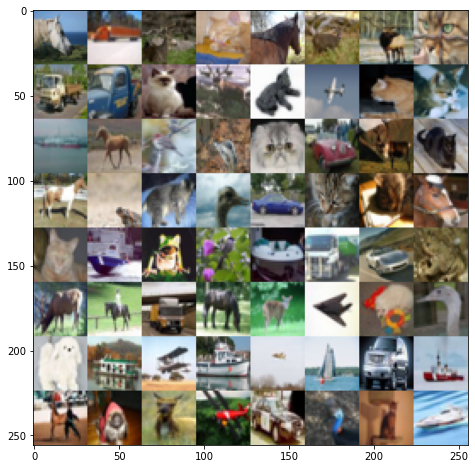

In [8]:
output = np.zeros((32 * 8, 32 * 8, 3), dtype=np.uint8)
row = 0

for data in train_data.batch(8).take(8):
    output[:, row*32:(row+1)*32] = np.vstack(data['image'].numpy())
    row += 1
plt.figure(figsize=(8,8))
plt.imshow(output)

In [9]:
def parse_fn(dataset):
    x = tf.cast(dataset['image'], tf.float32) / 255.
    y = tf.one_hot(dataset['label'], 10)
    return x, y

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 64
train_num = int(info.splits['train'].num_examples / 10) * 9

In [11]:
train_data = train_data.shuffle(train_num)
train_data = train_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

valid_data = valid_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
valid_data = valid_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

## Model 1

In [13]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Flatten()(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_1 = keras.Model(inputs, outputs, name='model-1')
model_1.summary()

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               393344    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               1315

In [14]:
model_dir = 'lab4-logs/models'
os.makedirs(model_dir)

In [15]:
log_dir = os.path.join('lab4-logs', 'model-1')

model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.h5', monitor='val_categorical_accuracy',
                                             save_best_only=True, mode='max')

In [16]:
model_1.compile(keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.CategoricalAccuracy()])

In [18]:
history_1 = model_1.fit(train_data, epochs=100, validation_data=valid_data, callbacks=[model_cbk, model_mckp])

Epoch 1/100
704/704 [==============================] - 15s 21ms/step - loss: 2.1252 - categorical_accuracy: 0.1697 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100
704/704 [==============================] - 13s 19ms/step - loss: 2.0960 - categorical_accuracy: 0.1820 - val_loss: 2.1083 - val_categorical_accuracy: 0.1838
Epoch 3/100
704/704 [==============================] - 13s 19ms/step - loss: 2.0738 - categorical_accuracy: 0.1993 - val_loss: 2.0508 - val_categorical_accuracy: 0.2226
Epoch 4/100
704/704 [==============================] - 14s 19ms/step - loss: 2.0581 - categorical_accuracy: 0.2061 - val_loss: 2.0626 - val_categorical_accuracy: 0.2176
Epoch 5/100
704/704 [==============================] - 14s 19ms/step - loss: 2.0585 - categorical_accuracy: 0.2056 - val_loss: 2.0103 - val_categorical_accuracy: 0.2302
Epoch 6/100
704/704 [==============================] - 14s 19ms/step - loss: 2.0453 - categorical_accuracy: 0.2124 - val_loss: 1.9958 - val_categor

## Model 2

In [20]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_2 = keras.Model(inputs, outputs, name='model-2')
model_2.summary()

Model: "model-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         295040    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          7379

In [21]:
log_dir = os.path.join('lab4-logs', 'model-2')

model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.h5', monitor='val_categorical_accuracy',
                                             save_best_only=True, mode='max')

In [22]:
model_2.compile(keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.CategoricalAccuracy()])

In [23]:
history_2 = model_2.fit(train_data, epochs=100, validation_data=valid_data, callbacks=[model_cbk, model_mckp])

Epoch 1/100
704/704 [==============================] - 60s 85ms/step - loss: 1.8716 - categorical_accuracy: 0.2872 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100
704/704 [==============================] - 80s 113ms/step - loss: 1.5048 - categorical_accuracy: 0.4495 - val_loss: 1.4593 - val_categorical_accuracy: 0.4972
Epoch 3/100
704/704 [==============================] - 86s 122ms/step - loss: 1.3229 - categorical_accuracy: 0.5273 - val_loss: 1.1570 - val_categorical_accuracy: 0.5932
Epoch 4/100
704/704 [==============================] - 88s 125ms/step - loss: 1.1992 - categorical_accuracy: 0.5748 - val_loss: 1.0820 - val_categorical_accuracy: 0.6138
Epoch 5/100
704/704 [==============================] - 90s 128ms/step - loss: 1.1154 - categorical_accuracy: 0.6077 - val_loss: 1.0873 - val_categorical_accuracy: 0.6098
Epoch 6/100
704/704 [==============================] - 90s 128ms/step - loss: 1.0351 - categorical_accuracy: 0.6380 - val_loss: 1.0059 - val_ca

## Image Augmentation

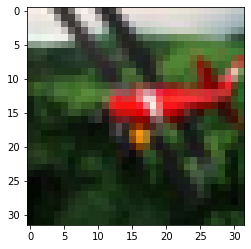

In [24]:
x = 3
y = 7
image_test = output[y*32:(y+1)*32, x*32:(x+1)*32, :]
plt.imshow(image_test)

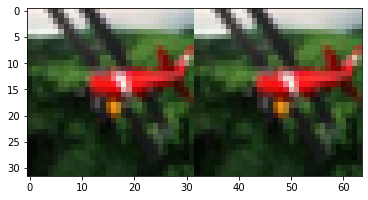

In [25]:
def flip(x):
    x = tf.image.random_flip_left_right(x)
    return x

image_2 = flip(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

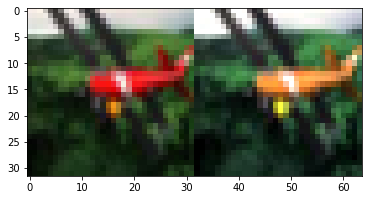

In [26]:
def color(x):
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    return x

image_2 = color(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

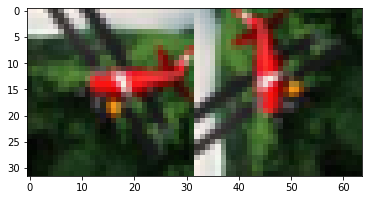

In [27]:
def rotate(x):
    x = tf.image.rot90(x, tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32))
    return x

image_2 = rotate(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

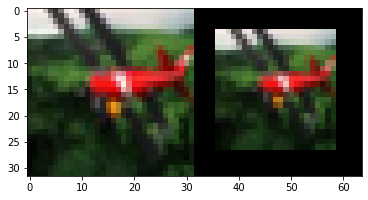

In [29]:
def zoom(x, scale_min=0.6, scale_max=1.4):
    h, w, c = x.shape
    scale = tf.random.uniform([], scale_min, scale_max)
    sh = h * scale
    sw = w * scale
    x = tf.image.resize(x, (sh, sw))
    x = tf.image.resize_with_crop_or_pad(x, h, w)
    return x

image_2 = zoom(image_test)
image_2 = tf.cast(image_2, dtype=tf.uint8)
image = np.hstack((image_test, image_2))
plt.imshow(image)

Reload data

In [30]:
train_data = tfds.load('cifar10', split='train[10%:100%]')

In [31]:
def parse_aug_fn(dataset):
    x = tf.cast(dataset['image'], tf.float32) / 255.
    x = flip(x)
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: color(x), lambda: x)
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: rotate(x), lambda: x)
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: zoom(x), lambda: x)
    y = tf.one_hot(dataset['label'], 10)
    return x, y

In [32]:
train_data = train_data.shuffle(train_num)
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

W0616 15:20:33.813257 23096 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


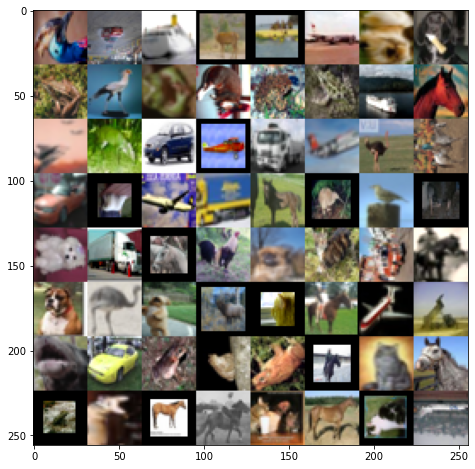

In [33]:
for images, labels in train_data.take(1):
    images = images.numpy()

output = np.zeros((32 * 8, 32 * 8, 3))

for i in range(8):
    for j in range(8):
        output[i*32:(i+1)*32, j*32:(j+1)*32, :] = images[i*8+j]

plt.figure(figsize=(8, 8))
plt.imshow(output)

## Model 3

In [35]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_3 = keras.Model(inputs, outputs, name='model-3')
model_3.summary()

Model: "model-3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 11, 11, 256)       295168    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 9, 9, 128)         295040    
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 64)          7379

In [37]:
log_dir = os.path.join('lab4-logs', 'model-3')

model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-3.h5', monitor='val_categorical_accuracy',
                                             save_best_only=True, mode='max')

In [42]:
model_3.compile(keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.CategoricalAccuracy()])

In [43]:
history_3 = model_3.fit(train_data, epochs=100, validation_data=valid_data, callbacks=[model_cbk, model_mckp])

Epoch 1/100
704/704 [==============================] - 57s 80ms/step - loss: 2.0530 - categorical_accuracy: 0.2238 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100
704/704 [==============================] - 64s 90ms/step - loss: 1.8293 - categorical_accuracy: 0.3319 - val_loss: 1.4777 - val_categorical_accuracy: 0.4754
Epoch 3/100
704/704 [==============================] - 74s 105ms/step - loss: 1.6774 - categorical_accuracy: 0.3946 - val_loss: 1.4150 - val_categorical_accuracy: 0.5058
Epoch 4/100
704/704 [==============================] - 89s 126ms/step - loss: 1.5929 - categorical_accuracy: 0.4277 - val_loss: 1.2165 - val_categorical_accuracy: 0.5670
Epoch 5/100
704/704 [==============================] - 90s 128ms/step - loss: 1.5120 - categorical_accuracy: 0.4641 - val_loss: 1.1881 - val_categorical_accuracy: 0.5800
Epoch 6/100
704/704 [==============================] - 87s 123ms/step - loss: 1.4646 - categorical_accuracy: 0.4880 - val_loss: 1.1032 - val_cat

## Evaluate

In [44]:
model_1.load_weights('lab4-logs/models/Best-model-1.h5')
model_2.load_weights('lab4-logs/models/Best-model-2.h5')
model_3.load_weights('lab4-logs/models/Best-model-3.h5')

In [45]:
loss_1, acc_1 = model_1.evaluate(test_data)
loss_2, acc_2 = model_2.evaluate(test_data)
loss_3, acc_3 = model_3.evaluate(test_data)

    157/Unknown - 5s 30ms/step - loss: 0.6361 - categorical_accuracy: 0.7969 4s 30ms/step - 5s 30ms/step - loss: 0.6389 - categorical_ac

In [47]:
loss = [loss_1, loss_2, loss_3]
acc = [acc_1, acc_2, acc_3]
dict = {'Accuracy': acc, 'Loss': loss}
pd.DataFrame(dict)

,Accuracy,Loss
0,0.2735,1.933864
1,0.6981,2.064832
2,0.7969,0.636067


In [51]:
%load_ext tensorboard
%tensorboard --logdir lab4-logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 3140.